In [1]:
import tess_stitch as tea
import big_data_funs as bd
import os
import matplotlib.pyplot as plt
from importlib import reload
from pathlib import Path
reload(tea)



import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from lightkurve.correctors import PLDCorrector
from astropy.constants import G, R_sun, M_sun, R_earth
from astroquery.mast import Catalogs
import warnings
import json
import os
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from numpy import ma 
warnings.filterwarnings("ignore")


In [2]:
TARGET = "TOI-4010"
METODO = "LCF"  # LCF o TPF
PCA_COMPONENTS = 5 

In [3]:

def get_multisector_lc(target_name, method="LCF", author="SPOC", pca_components=5):
    """
    Descarga, filtra y unifica sectores.
    """
    print(f"--- Buscando datos para {target_name} [{method}] ---")
    
    if method == "LCF":
        search = lk.search_lightcurve(target_name, author=author)
    elif method =="TPF":
        search = lk.search_targetpixelfile(target_name)
        if len(search) == 0:
            search = lk.search_tesscut(target_name)

    if len(search) == 0:
        print("No se encontraron datos.")
        return None
    
    valid_lcs = []

    for item in search[0]:
        try:
            if method == "LCF":
                lc = item.download(quality_bitmask='default')

            lc = lc.remove_nans().normalize().remove_outliers(sigma=5)

            if len(lc) < 100:
                continue
                            
            if np.nanstd(lc.flux) < 1e-5: 
                continue

            valid_lcs.append(lc)
            
        except Exception as e:
            continue

    if len(valid_lcs) == 0:
        print("No tenemos datos válidos de calidad")
        return None

    lc_stitched = lk.LightCurveCollection(valid_lcs).stitch().remove_nans()
    
    return lc_stitched


def clean_lc(lc, window_length=1001, sigma=5):
    ''' 
    Limpieza de lightcurve (flateneado + remove outliers)
    '''
    if lc is None: return None
    clc = lc.copy()
    if window_length % 2 == 0: window_length += 1
    clc = clc.flatten(window_length=window_length, break_tolerance=10).remove_outliers(sigma=sigma)
    return clc



def bls(lc, min_p=0.5, max_p=30, n_points=100000):
    '''
    Ejecutar box least squares
    '''
    if lc is None: return None
    
    periodogram = lc.to_periodogram(
        method='bls', 
        period=np.linspace(min_p, max_p, n_points),
        frequency_factor=1000 
    )

In [4]:
lc_stitched = get_multisector_lc(
    TARGET, 
    method=METODO, 
    pca_components=PCA_COMPONENTS
)

if lc_stitched is not None:
    
    lc_clean = clean_lc(lc_stitched, window_length=2001, sigma=5)

else:
    print("No se pudieron obtener datos para el análisis.")

--- Buscando datos para TOI-4010 [LCF] ---


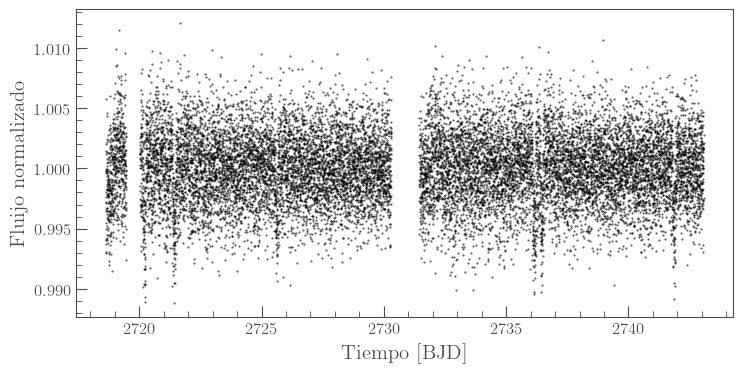

In [5]:
lc_clean


import matplotlib.pyplot as plt

# Configuración para usar LM Roman en el plot
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"], # Equivalente estándar a LM Roman en LaTeX
    "axes.labelsize": 12,
    "xtick.direction": "in",
    "ytick.direction": "in"
})

# Plotting
ax = lc_clean.scatter(s=1, color='black', alpha=0.7)

# Refinamiento de etiquetas con LaTeX
ax.set_xlabel('Tiempo [BJD]')
ax.set_ylabel('Fluijo normalizado')
ax.legend().remove()


plt.show()
plt.close()

EJECUTAR EL DE ABAJO (MAYOR CALIDAD)

Calculando rejilla BLS...
Cálculo terminado.
Renderizando layout complejo en alta resolución (300 DPI)... Esto tomará tiempo.
¡Renderizado completado! Revisa 'bls_dashboard_final.mp4'


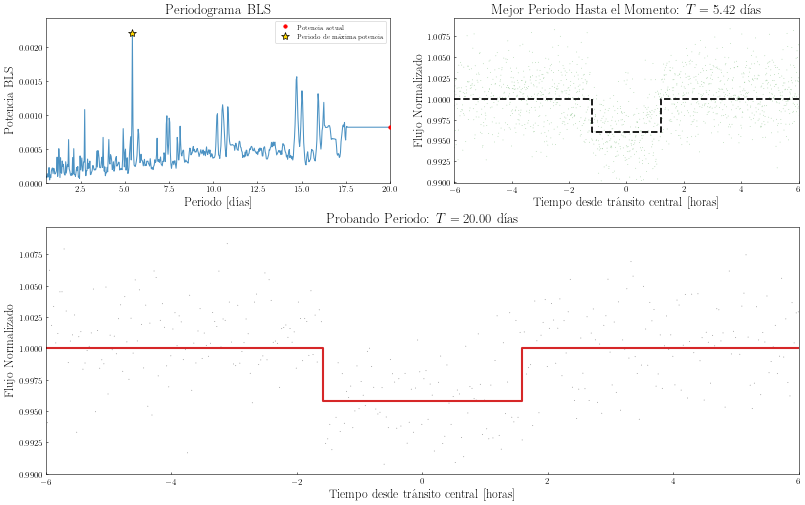

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.gridspec import GridSpec # Importante para el nuevo layout
from astropy.timeseries import BoxLeastSquares
import astropy.units as u

# --- 1. CONFIGURACIÓN DE ALTA CALIDAD ---
# Asegúrate de que esta ruta sigue siendo válida en tu máquina
plt.rcParams['animation.ffmpeg_path'] = r'C:\Users\jorge\AppData\Local\Microsoft\WinGet\Packages\Gyan.FFmpeg_Microsoft.WinGet.Source_8wekyb3d8bbwe\ffmpeg-8.0.1-full_build\bin\ffmpeg.exe'

plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{lmodern}",
    "font.family": "serif",
    "font.serif": ["Latin Modern Roman"],
    "figure.dpi": 50, # Reducido ligeramente para visualización en pantalla, el guardado será 300
    "savefig.dpi": 300
})

plt.rcParams.update({
    "xtick.labelsize": 13,
    "ytick.labelsize": 13
})

# --- 2. DATOS Y PROCESAMIENTO (Asumiendo lc_clean existe) ---
t, f = lc_clean.time.value, lc_clean.flux.value


model = BoxLeastSquares(t * u.day, f)
n_frames = 600
periods = np.linspace(0.5, 20, n_frames) * u.day
durations = np.linspace(0.04, 0.25, 15) * u.day
print("Calculando rejilla BLS...")
results = model.power(periods, durations)
print("Cálculo terminado.")

# --- 3. CONFIGURACIÓN GRÁFICA CON GRIDSPEC ---
fig = plt.figure(figsize=(16, 10), constrained_layout=True)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1, 1.5]) 

# Definición de los Axes
ax_p = fig.add_subplot(gs[0, 0])      # Arriba Izquierda (Periodograma)
ax_best = fig.add_subplot(gs[0, 1])   # Arriba Derecha (Mejor Tránsito)
ax_dyn = fig.add_subplot(gs[1, :])    # Abajo (Tránsito Dinámico, ocupa 2 columnas)

# Configuración Común (Límites Y para los tránsitos)
flux_ylim = (np.percentile(f, 0.05), np.percentile(f, 99.95))
window_hrs = 6.0
label_time = r"$\text{Tiempo desde tránsito central [horas]}$"
label_flux = r"$\text{Flujo Normalizado}$"

# --- SETUP AX_P (Periodograma - Arriba Izq) ---
line_p, = ax_p.plot([], [], c='#1f77b4', lw=1.5, alpha=0.8)
point_p, = ax_p.plot([], [], 'ro', ms=5, zorder=5, label=r'$\text{Potencia actual}$')
# La estrella dorada para el mejor
star_best, = ax_p.plot([], [], color='gold', marker='*', ms=12, markeredgecolor='black', zorder=10, linestyle='None', label=r'$\text{Periodo de máxima potencia}$')
ax_p.set_xlabel(r"$\text{Periodo [días]}$", fontsize=18)
ax_p.set_ylabel(r"$\text{Potencia BLS}$", fontsize=18)
ax_p.set_xlim(periods.min().value, periods.max().value)
ax_p.set_ylim(0, np.max(results.power) * 1.1)
ax_p.legend(loc='upper right', frameon=True)
ax_p.set_title(r"$\text{Periodograma BLS}$", fontsize=20)

# --- SETUP AX_BEST (Mejor Tránsito - Arriba Der) ---
scat_best = ax_best.scatter([], [], s=1.5, c='forestgreen', alpha=0.4, edgecolors='none')
line_box_best, = ax_best.plot([], [], c='black', lw=2.5, linestyle='--')
ax_best.set_xlabel(label_time, fontsize=18)
ax_best.set_ylabel(label_flux, fontsize=18)
ax_best.set_xlim(-window_hrs, window_hrs)
ax_best.set_ylim(flux_ylim)
title_best = ax_best.set_title(r"$\text{Mejor Periodo Hasta el Momento}$", fontsize=20, color='k')

# --- SETUP AX_DYN (Dinámico - Abajo Grande) ---
scat_dyn = ax_dyn.scatter([], [], s=2, c='black', alpha=0.4, edgecolors='none')
line_box_dyn, = ax_dyn.plot([], [], c='#d62728', lw=3)
ax_dyn.set_xlabel(label_time, fontsize=18)
ax_dyn.set_ylabel(label_flux, fontsize=18)
ax_dyn.set_xlim(-window_hrs, window_hrs)
ax_dyn.set_ylim(flux_ylim)
title_dyn = ax_dyn.set_title(r"$\text{Faseado en tiempo real}$", fontsize=20)

# --- 4. UPDATE FUNCTION ---
def update(i):
    # -- Datos del frame actual --
    p_curr = results.period[i].value
    pow_curr = results.power[i]
    
    # -- Encontrar el mejor HASTA AHORA --
    # Buscamos el índice del máximo en el array histórico
    best_idx_so_far = np.argmax(results.power[:i+1])
    
    # Datos del mejor hasta ahora
    p_best = results.period[best_idx_so_far].value
    pow_best = results.power[best_idx_so_far]
    t0_best = results.transit_time[best_idx_so_far].value
    dur_best = results.duration[best_idx_so_far].value
    depth_best = results.depth[best_idx_so_far]
    
    # --- ACTUALIZAR PERIODOGRAMA (Arriba Izq) ---
    line_p.set_data(results.period[:i+1].value, results.power[:i+1])
    point_p.set_data([p_curr], [pow_curr])
    star_best.set_data([p_best], [pow_best]) # La estrella sigue al mejor histórico

    # --- ACTUALIZAR MEJOR TRÁNSITO (Arriba Der) ---
    # Faseo con los parámetros del mejor
    t_rel_best = ((t - t0_best + 0.5 * p_best) % p_best - 0.5 * p_best) * 24
    scat_best.set_offsets(np.c_[t_rel_best, f])
    
    # Modelo de caja del mejor
    h_dur_best = (dur_best * 24) / 2
    bx_b = [-window_hrs, -h_dur_best, -h_dur_best, h_dur_best, h_dur_best, window_hrs]
    by_b = [1.0, 1.0, 1.0 - depth_best, 1.0 - depth_best, 1.0, 1.0]
    line_box_best.set_data(bx_b, by_b)
    
    title_best.set_text(r"$\text{Mejor Periodo Hasta el Momento: } T = %.2f \text{ d\'ias}$" % (p_best))

    # --- ACTUALIZAR TRÁNSITO DINÁMICO (Abajo) ---
    # Datos del frame actual i
    t0_curr = results.transit_time[i].value
    dur_curr = results.duration[i].value
    depth_curr = results.depth[i]
    
    t_rel_curr = ((t - t0_curr + 0.5 * p_curr) % p_curr - 0.5 * p_curr) * 24
    scat_dyn.set_offsets(np.c_[t_rel_curr, f])
    
    h_dur_curr = (dur_curr * 24) / 2
    bx_d = [-window_hrs, -h_dur_curr, -h_dur_curr, h_dur_curr, h_dur_curr, window_hrs]
    by_d = [1.0, 1.0, 1.0 - depth_curr, 1.0 - depth_curr, 1.0, 1.0]
    line_box_dyn.set_data(bx_d, by_d)
    
    title_dyn.set_text(r"$\text{Probando Periodo: } T = %.2f \text{ d\'ias}$" % p_curr)

    # Devolver TODOS los artistas animados
    return (line_p, point_p, star_best, 
            scat_best, line_box_best, title_best,
            scat_dyn, line_box_dyn, title_dyn)

# --- 5. RENDERIZADO DE ULTRA CALIDAD ---
# Usamos blit=True y devolvemos los títulos para que se actualicen suavemente
ani = FuncAnimation(fig, update, frames=len(periods), interval=33, blit=True)

# Configuración máxima calidad
writer = FFMpegWriter(fps=30, bitrate=6000, metadata=dict(artist='Jorge Acebes'))

print("Renderizando layout complejo en alta resolución (300 DPI)... Esto tomará tiempo.")
# Usamos savefig_kwargs para pasar el DPI alto solo al guardado final
ani.save('bls_dashboard_final.mp4', writer=writer, dpi=300, savefig_kwargs={'pad_inches': 0.1})
print("¡Renderizado completado! Revisa 'bls_dashboard_final.mp4'")

plt.show()
plt.close()